In [8]:
# !pip install xgboost

In [9]:
# Importing necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re

In [10]:
# Advanced text processing and models
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [11]:
# Download NLTK resources 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================
# This section assumes you have access to the MIMIC-III database and have run SQL queries
# to extract the necessary data for the first 24 hours of ICU stay for patients.
# To extract structured data and notes data for first 24 hours, SQL queries present at the end of this notebook can be used.
# I used Google Big Query to run these queries on MIMIC-III dataset hosted on Google Cloud.
# You should have one file for structured data (vitals, labs, demographics)
# and one file for the notes.

print("Loading data...")
# df_structured should have columns like 'subject_id', 'hadm_id', 'icustay_id', 
# 'age', 'gender', 'heart_rate_mean', 'wbc_min', etc., and the target 'hospital_expire_flag'
df_structured = pd.read_csv('structured_data_first_24h.csv')
print(df_structured.columns)
# print(df_structured.head(1))

# df_notes should have 'icustay_id' and 'text'
df_notes = pd.read_csv('notes_data_first_24h.csv')
print(df_notes.columns)
# print(df_notes.head(1))
# Merge to ensure we only have patients present in both datasets
df_combined = pd.merge(df_structured, df_notes, on='icustay_id')

print("Data loaded. Number of records:", len(df_combined))

Loading data...
Index(['subject_id', 'hadm_id', 'icustay_id', 'age', 'gender',
       'hospital_expire_flag', 'heart_rate_min', 'heart_rate_max',
       'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'spo2_min',
       'spo2_max', 'spo2_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'wbc_min', 'wbc_max', 'wbc_mean', 'creatinine_min', 'creatinine_max',
       'creatinine_mean'],
      dtype='object')
Index(['icustay_id', 'text'], dtype='object')
Data loaded. Number of records: 28227


In [13]:
# =============================================================================
# FEATURE ENGINEERING & DATA SPLIT
# =============================================================================
# To train and evaluate models, we will split the data into training and testing sets.

print("Splitting data into training and testing sets...")
# Define features (X) and target (y)
X_structured = df_combined.drop(columns=['subject_id', 'hadm_id', 'icustay_id', 'hospital_expire_flag', 'text'])
X_text = df_combined['text']
y = df_combined['hospital_expire_flag']

# Split data into training and testing sets
# Using train_test_split from sklearn to achieve an 80-20 split with stratification on the target variable
X_struct_train, X_struct_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_structured, X_text, y, test_size=0.2, random_state=42, stratify=y
)

#check number of samples in each set
print("Training set size:", len(y_train))
print("Testing set size:", len(y_test))
print("Number of positive cases in training set:", sum(y_train))
print("Number of positive cases in testing set:", sum(y_test))



Splitting data into training and testing sets...
Training set size: 22581
Testing set size: 5646
Number of positive cases in training set: 2597
Number of positive cases in testing set: 649


In [14]:
# --- Process Structured Data ---
print("Processing structured data...")

# As a simple approach, we will impute missing values with the mean for numeric columns
# and scale the features using StandardScaler.
# Separate numeric and categorical columns
numeric_columns = X_struct_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X_struct_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Impute and scale numeric columns
imputer = SimpleImputer(strategy='mean')
X_train_num = pd.DataFrame(imputer.fit_transform(X_struct_train[numeric_columns]), columns=numeric_columns, index=X_struct_train.index)
X_test_num = pd.DataFrame(imputer.transform(X_struct_test[numeric_columns]), columns=numeric_columns, index=X_struct_test.index)

#scale the features using StandardScaler
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=numeric_columns, index=X_struct_train.index)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=numeric_columns, index=X_struct_test.index)

# If there are categorical columns, we will one-hot encode them.
# for example, Gender column might have Male/Female but our model will need numeric values.
# One-hot encode categorical columns (if any)
# For simplicity, we will use pandas get_dummies

if categorical_columns:
    X_train_cat = pd.get_dummies(X_struct_train[categorical_columns], dummy_na=True)
    X_test_cat = pd.get_dummies(X_struct_test[categorical_columns], dummy_na=True)
    # Align columns in case some categories are missing in test/train
    X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='left', axis=1, fill_value=0)
    X_test_cat = X_test_cat.fillna(0)
    # Combine numeric and categorical
    X_struct_train_scaled = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
    X_struct_test_scaled = pd.concat([X_test_num_scaled, X_test_cat], axis=1)
else:
    X_struct_train_scaled = X_train_num_scaled
    X_struct_test_scaled = X_test_num_scaled

Processing structured data...


In [15]:
# --- Process Text Data ---

print("Processing text data with advanced preprocessing...")

# We'll reduce words to their base form using lemmatization, remove stopwords, and clean the text.
# for example, converting "running" to "run", removing common words like "the", "is", etc.
# Advanced text cleaning and lemmatization
def clean_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text) # Remove de-identification brackets
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and numbers
    text = text.strip() # Remove extra whitespace
    return text

stop_words = set(stopwords.words('english')) # Common English stopwords

# Initialize lemmatizer. This was imported from nltk above.
lemmatizer = WordNetLemmatizer()

# Preprocess text: clean, remove stopwords, lemmatize
def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

X_text_train_clean = X_text_train.apply(preprocess_text)
X_text_test_clean = X_text_test.apply(preprocess_text)

# Use n-gram TF-IDF vectorizer (unigrams + bigrams)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_text_train_tfidf = vectorizer.fit_transform(X_text_train_clean)
X_text_test_tfidf = vectorizer.transform(X_text_test_clean)

Processing text data with advanced preprocessing...


In [16]:
# =============================================================================
# MODEL TRAINING
# =============================================================================

# Running different models on structured and text data separately to check their performance.
print("Training individual models...")


# --- Model 1: XGBoost on Structured Data ---
# Using XGBoost classifier for structured data
# XGBoost is effective for tabular data and can handle missing values internally.
model_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                              use_label_encoder=False, random_state=42)
model_xgb.fit(X_struct_train_scaled, y_train)

# --- Model 2: Logistic Regression on Text Data ---
# Using Logistic Regression on TF-IDF text features
# Logistic Regression is a simple yet effective model for text classification.
model_lr_text = LogisticRegression(max_iter=800, random_state=42)
model_lr_text.fit(X_text_train_tfidf, y_train)

# --- Model 3: Random Forest on Text Data ---
# Using Random Forest Classifier on TF-IDF text features
# Random Forests can capture non-linear relationships and interactions in the data.
model_rf_text = RandomForestClassifier(n_estimators=125, random_state=45, n_jobs=-1)
model_rf_text.fit(X_text_train_tfidf, y_train)

Training individual models...


c:\Users\varun\.conda\envs\deepl\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:09:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,n_estimators,125
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
# =============================================================================
# ENSEMBLE MODEL - Combines predictions from multiple base models.
# It leverages the strengths of each individual model to improve overall performance and can reduce errors.
# =============================================================================
print("Training ensemble model...")

# Get predictions (probabilities) from base models on the test set
#  We will use these predictions as features for the ensemble model.
preds_xgb = model_xgb.predict_proba(X_struct_test_scaled)[:, 1]
preds_lr_text = model_lr_text.predict_proba(X_text_test_tfidf)[:, 1]

# To properly train the ensemble, we need out-of-fold predictions.
# A simpler approach for this tutorial is to just evaluate the stacked performance on the test set.
# A more robust method would use cross-validation.

# For demonstration, let's train a simple meta-model on the training set predictions
train_preds_xgb = model_xgb.predict_proba(X_struct_train_scaled)[:, 1]
train_preds_lr_text = model_lr_text.predict_proba(X_text_train_tfidf)[:, 1]

# Create new feature set for the meta-model
X_train_ensemble = np.c_[train_preds_xgb, train_preds_lr_text]
X_test_ensemble = np.c_[preds_xgb, preds_lr_text]

# Train the meta-model (Logistic Regression)
model_ensemble = LogisticRegression(random_state=45)
model_ensemble.fit(X_train_ensemble, y_train)

Training ensemble model...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,45
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [18]:
# =============================================================================
# EVALUATION
# =============================================================================

# Create folder for plots
os.makedirs('plots', exist_ok=True)

print("Evaluating models...")
# Evaluate individual models

# Get final predictions from all models
final_preds_xgb = preds_xgb # XGBoost predictions
final_preds_lr_text = preds_lr_text # Logistic Regression on Text Data predictions
final_preds_rf_text = model_rf_text.predict_proba(X_text_test_tfidf)[:, 1] # Random Forest on Text Data predictions
final_preds_ensemble = model_ensemble.predict_proba(X_test_ensemble)[:, 1] # Ensemble model predictions

# Calculate AUROC scores
# AUROC is a common metric for binary classification tasks, especially in imbalanced datasets.
auroc_xgb = roc_auc_score(y_test, final_preds_xgb)
auroc_lr_text = roc_auc_score(y_test, final_preds_lr_text)
auroc_rf_text = roc_auc_score(y_test, final_preds_rf_text)
auroc_ensemble = roc_auc_score(y_test, final_preds_ensemble)

Evaluating models...


AUROC for Structured Data Model (XGBoost): 0.8119
AUROC for Text Data Model (LogReg): 0.9018
AUROC for Text Data Model (Random Forest): 0.8623
AUROC for Ensemble Model: 0.8838


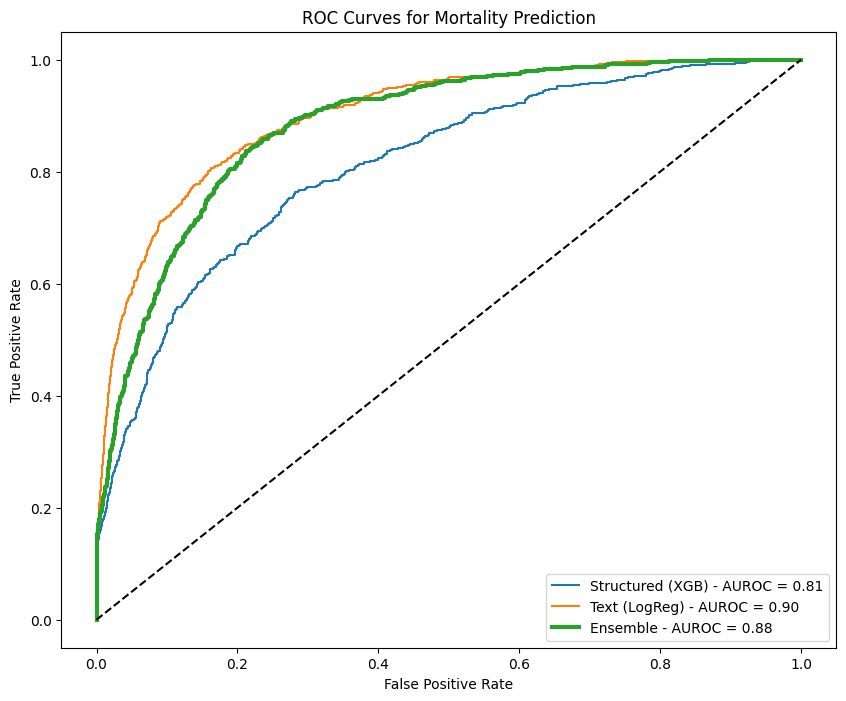

In [19]:
# Print AUROC scores
print(f"AUROC for Structured Data Model (XGBoost): {auroc_xgb:.4f}")
print(f"AUROC for Text Data Model (LogReg): {auroc_lr_text:.4f}")
print(f"AUROC for Text Data Model (Random Forest): {auroc_rf_text:.4f}")
print(f"AUROC for Ensemble Model: {auroc_ensemble:.4f}")

# Plot ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, final_preds_xgb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, final_preds_lr_text)
fpr_ens, tpr_ens, _ = roc_curve(y_test, final_preds_ensemble)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'Structured (XGB) - AUROC = {auroc_xgb:.2f}')
plt.plot(fpr_lr, tpr_lr, label=f'Text (LogReg) - AUROC = {auroc_lr_text:.2f}')
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble - AUROC = {auroc_ensemble:.2f}', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plt.title('ROC Curves for Mortality Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# --- Save ROC Curve Plot ---
plt.savefig('plots/roc_curves.png')
plt.close()

C:\Users\varun\AppData\Local\Temp\ipykernel_2648\36924165.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x600 with 0 Axes>

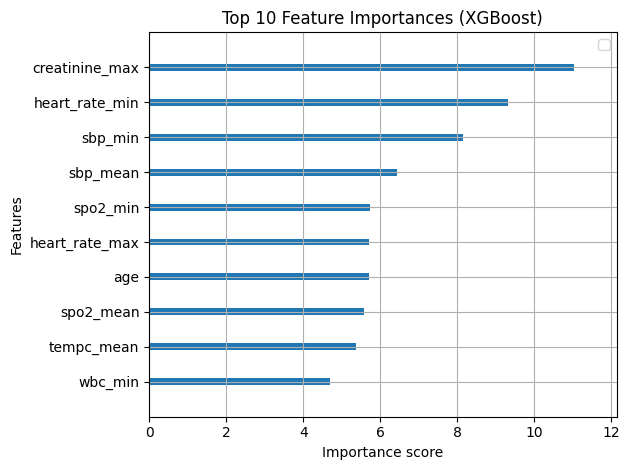

In [20]:
# --- Feature Importance for Structured Data (XGBoost) ---
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_xgb, max_num_features=10, 
                    importance_type='gain', show_values=False)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.tight_layout()
plt.legend()
plt.show()
plt.savefig('plots/xgb_feature_importance.png')
plt.close()

C:\Users\varun\AppData\Local\Temp\ipykernel_2648\2336573771.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


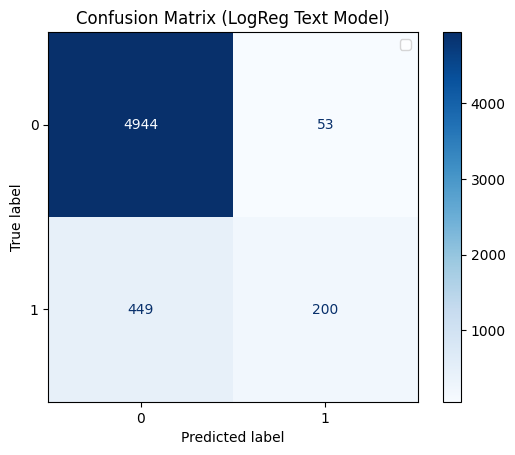

In [21]:
# --- Confusion Matrix for Best Text Model (LogReg or RF) ---
best_text_preds = final_preds_lr_text if auroc_lr_text >= auroc_rf_text else final_preds_rf_text
best_text_label = 'LogReg' if auroc_lr_text >= auroc_rf_text else 'Random Forest'
cm = confusion_matrix(y_test, best_text_preds > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix ({best_text_label} Text Model)')
plt.legend()
plt.show()
plt.savefig(f'plots/confusion_matrix_{best_text_label.lower()}.png')
plt.close()

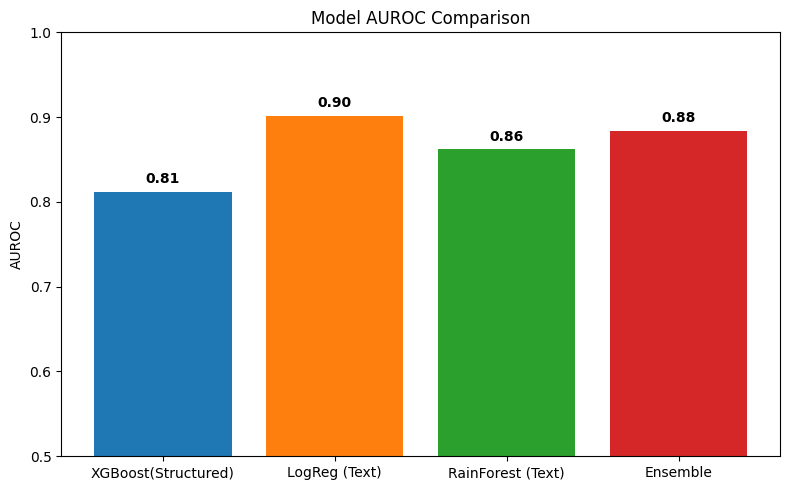

In [25]:
# --- Bar Plot of AUROC Scores ---
plt.figure(figsize=(8, 5))
models = ['XGBoost(Structured)', 'LogReg (Text)', 'RainForest (Text)', 'Ensemble']
aucs = [auroc_xgb, auroc_lr_text, auroc_rf_text, auroc_ensemble]
plt.bar(models, aucs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim(0.5, 1.0)
plt.ylabel('AUROC')
plt.title('Model AUROC Comparison')
for i, v in enumerate(aucs):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig('plots/auroc_comparison.png')
plt.close()

### Model AUROC Comparison and Interpretation
The bar plot above compares the AUROC (Area Under the Receiver Operating Characteristic curve) scores for four different models:
- **XGBoost (Structured Data):** 0.81
- **Logistic Regression (Text Data):** 0.90
- **Random Forest (Text Data):** 0.86
- **Ensemble (Stacked):** 0.88

**Interpretation:**
- **Logistic Regression on text data achieved the highest AUROC (0.90),** indicating that clinical notes contain highly predictive information for mortality risk in the first 24 hours of ICU stay. This model is best at distinguishing between patients who survived and those who did not, based on text features alone.
- **Random Forest on text data also performed well (0.86),** but slightly below Logistic Regression, suggesting that linear relationships in the text features are most predictive for this task.
- **XGBoost on structured data achieved an AUROC of 0.81,** showing that vital signs, labs, and demographics are useful but less predictive than the text notes in this dataset.
- **The Ensemble model (0.88) combines predictions from both structured and text models,** leveraging the strengths of each. While it does not surpass the best single model (Logistic Regression on text), it outperforms XGBoost and Random Forest individually, indicating that combining different data sources can improve overall performance.

**Conclusion:**
- Text data (clinical notes) is highly informative for early mortality prediction in the ICU, as shown by the superior performance of text-based models.
- Combining structured and text data via ensembling provides a robust approach, though in this case, the text model alone was strongest.

In [23]:
## Notes Data SQL query to prepare Data

"""

WITH first_stays AS (
  -- This CTE identifies the cohort and remains the same
  SELECT
    p.subject_id,
    a.hadm_id,
    i.icustay_id,
    i.intime
  FROM
    `physionet-data.mimiciii_clinical.patients` p
  INNER JOIN
    `physionet-data.mimiciii_clinical.admissions` a ON p.subject_id = a.subject_id
  INNER JOIN
    `physionet-data.mimiciii_clinical.icustays` i ON a.hadm_id = i.hadm_id
  WHERE
    TIMESTAMP_DIFF(i.intime, p.dob, YEAR) > 18
  QUALIFY
    ROW_NUMBER() OVER(PARTITION BY p.subject_id ORDER BY i.intime) = 1
)
SELECT
  fs.icustay_id,
  STRING_AGG(ne.text, ' ') AS text
FROM
  first_stays fs
LEFT JOIN
  `physionet-data.mimiciii_notes.noteevents` ne
  ON fs.hadm_id = ne.hadm_id
WHERE
  ne.charttime BETWEEN fs.intime AND TIMESTAMP_ADD(fs.intime, INTERVAL 24 HOUR)
  AND ne.category IN ('Nursing/other', 'Physician', 'Nursing')
  AND ne.iserror IS NULL
GROUP BY
  fs.icustay_id;
  
  """

"\n\nWITH first_stays AS (\n  -- This CTE identifies the cohort and remains the same\n  SELECT\n    p.subject_id,\n    a.hadm_id,\n    i.icustay_id,\n    i.intime\n  FROM\n    `physionet-data.mimiciii_clinical.patients` p\n  INNER JOIN\n    `physionet-data.mimiciii_clinical.admissions` a ON p.subject_id = a.subject_id\n  INNER JOIN\n    `physionet-data.mimiciii_clinical.icustays` i ON a.hadm_id = i.hadm_id\n  WHERE\n    TIMESTAMP_DIFF(i.intime, p.dob, YEAR) > 18\n  QUALIFY\n    ROW_NUMBER() OVER(PARTITION BY p.subject_id ORDER BY i.intime) = 1\n)\nSELECT\n  fs.icustay_id,\n  STRING_AGG(ne.text, ' ') AS text\nFROM\n  first_stays fs\nLEFT JOIN\n  `physionet-data.mimiciii_notes.noteevents` ne\n  ON fs.hadm_id = ne.hadm_id\nWHERE\n  ne.charttime BETWEEN fs.intime AND TIMESTAMP_ADD(fs.intime, INTERVAL 24 HOUR)\n  AND ne.category IN ('Nursing/other', 'Physician', 'Nursing')\n  AND ne.iserror IS NULL\nGROUP BY\n  fs.icustay_id;\n  \n  "

In [24]:
## Structured Data SQL query to prepare Data

"""
WITH first_stays AS (
  -- First, select the first ICU stay for each adult patient
  SELECT
    p.subject_id,
    a.hadm_id,
    i.icustay_id,
    i.intime,
    i.outtime,
    TIMESTAMP_DIFF(i.intime, p.dob, YEAR) AS age,
    p.gender,
    a.hospital_expire_flag
  FROM
    `physionet-data.mimiciii_clinical.patients` p
  INNER JOIN
    `physionet-data.mimiciii_clinical.admissions` a ON p.subject_id = a.subject_id
  INNER JOIN
    `physionet-data.mimiciii_clinical.icustays` i ON a.hadm_id = i.hadm_id
  WHERE
    TIMESTAMP_DIFF(i.intime, p.dob, YEAR) > 18 -- Filter for adult patients first
  QUALIFY
    ROW_NUMBER() OVER(PARTITION BY p.subject_id ORDER BY i.intime) = 1 -- Then select the first stay
),
vitals_and_labs AS (
  -- Next, get all relevant chartevents and labevents within the first 24 hours
  SELECT
    fs.icustay_id,
    CASE WHEN ce.itemid IN (211, 220045) THEN ce.valuenum END AS heart_rate,
    CASE WHEN ce.itemid IN (51, 442, 455, 6701, 220179, 220050) THEN ce.valuenum END AS sbp,
    CASE WHEN ce.itemid IN (646, 220277) THEN ce.valuenum END AS spo2,
    CASE WHEN ce.itemid IN (223761, 678) THEN (ce.valuenum - 32) * 5/9 WHEN ce.itemid IN (223762, 676) THEN ce.valuenum END AS tempc,
    CASE WHEN le.itemid = 51301 THEN le.valuenum END AS wbc,
    CASE WHEN le.itemid = 50912 THEN le.valuenum END AS creatinine
  FROM
    first_stays fs
  LEFT JOIN
    `physionet-data.mimiciii_clinical.chartevents` ce ON fs.icustay_id = ce.icustay_id
    AND ce.charttime BETWEEN fs.intime AND TIMESTAMP_ADD(fs.intime, INTERVAL 24 HOUR)
  LEFT JOIN
     `physionet-data.mimiciii_clinical.labevents` le ON fs.hadm_id = le.hadm_id
    AND le.charttime BETWEEN fs.intime AND TIMESTAMP_ADD(fs.intime, INTERVAL 24 HOUR)
)
-- Finally, aggregate the pivoted data to create one row per ICU stay
SELECT
  fs.subject_id,
  fs.hadm_id,
  fs.icustay_id,
  fs.age,
  fs.gender,
  fs.hospital_expire_flag,
  MIN(vl.heart_rate) AS heart_rate_min,
  MAX(vl.heart_rate) AS heart_rate_max,
  AVG(vl.heart_rate) AS heart_rate_mean,
  MIN(vl.sbp) AS sbp_min,
  MAX(vl.sbp) AS sbp_max,
  AVG(vl.sbp) AS sbp_mean,
  MIN(vl.spo2) AS spo2_min,
  MAX(vl.spo2) AS spo2_max,
  AVG(vl.spo2) AS spo2_mean,
  MIN(vl.tempc) AS tempc_min,
  MAX(vl.tempc) AS tempc_max,
  AVG(vl.tempc) AS tempc_mean,
  MIN(vl.wbc) AS wbc_min,
  MAX(vl.wbc) AS wbc_max,
  AVG(vl.wbc) AS wbc_mean,
  MIN(vl.creatinine) AS creatinine_min,
  MAX(vl.creatinine) AS creatinine_max,
  AVG(vl.creatinine) AS creatinine_mean
FROM
  first_stays fs
LEFT JOIN
  vitals_and_labs vl ON fs.icustay_id = vl.icustay_id
GROUP BY
  fs.subject_id,
  fs.hadm_id,
  fs.icustay_id,
  fs.age,
  fs.gender,
  fs.hospital_expire_flag
ORDER BY
  fs.subject_id;
  
  """

'\nWITH first_stays AS (\n  -- First, select the first ICU stay for each adult patient\n  SELECT\n    p.subject_id,\n    a.hadm_id,\n    i.icustay_id,\n    i.intime,\n    i.outtime,\n    TIMESTAMP_DIFF(i.intime, p.dob, YEAR) AS age,\n    p.gender,\n    a.hospital_expire_flag\n  FROM\n    `physionet-data.mimiciii_clinical.patients` p\n  INNER JOIN\n    `physionet-data.mimiciii_clinical.admissions` a ON p.subject_id = a.subject_id\n  INNER JOIN\n    `physionet-data.mimiciii_clinical.icustays` i ON a.hadm_id = i.hadm_id\n  WHERE\n    TIMESTAMP_DIFF(i.intime, p.dob, YEAR) > 18 -- Filter for adult patients first\n  QUALIFY\n    ROW_NUMBER() OVER(PARTITION BY p.subject_id ORDER BY i.intime) = 1 -- Then select the first stay\n),\nvitals_and_labs AS (\n  -- Next, get all relevant chartevents and labevents within the first 24 hours\n  SELECT\n    fs.icustay_id,\n    CASE WHEN ce.itemid IN (211, 220045) THEN ce.valuenum END AS heart_rate,\n    CASE WHEN ce.itemid IN (51, 442, 455, 6701, 220179, 